In [124]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torchsummary import summary

In [125]:
# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
data = pd.read_csv(url)

data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [126]:
# 'Outcome' 컬럼 제거 (회귀 문제로 변경)
data.drop(columns=['Outcome'], inplace=True)

data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [127]:
y = data['BMI'].values
X = data.drop(columns=['BMI'])

In [128]:
# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [129]:
# 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [130]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [131]:
# DataLoader 구성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 모델 정의

In [132]:
class BMIDenseRegressor(nn.Module):
    def __init__(self):
        super(BMIDenseRegressor, self).__init__()
        self.fc1 = nn.Linear(7, 64)  # 8개 feature 중 BMI 제거했으니 7개 입력
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 회귀 문제는 출력 노드 1개

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # 회귀에서는 보통 활성화 함수 없음

## 학습

In [133]:
model = BMIDenseRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # 평가
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    test_losses.append(total_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch 1/20, Train Loss: 1083.1838, Test Loss: 982.6601
Epoch 2/20, Train Loss: 1027.0346, Test Loss: 912.5398
Epoch 3/20, Train Loss: 913.8652, Test Loss: 799.7570
Epoch 4/20, Train Loss: 769.1478, Test Loss: 639.4822
Epoch 5/20, Train Loss: 572.1075, Test Loss: 447.4118
Epoch 6/20, Train Loss: 370.5675, Test Loss: 268.7719
Epoch 7/20, Train Loss: 203.0068, Test Loss: 153.0249
Epoch 8/20, Train Loss: 121.6649, Test Loss: 107.3174
Epoch 9/20, Train Loss: 95.9288, Test Loss: 93.1400
Epoch 10/20, Train Loss: 86.4674, Test Loss: 86.6964
Epoch 11/20, Train Loss: 81.6025, Test Loss: 81.4900
Epoch 12/20, Train Loss: 81.7851, Test Loss: 78.2521
Epoch 13/20, Train Loss: 72.6268, Test Loss: 74.9445
Epoch 14/20, Train Loss: 72.4637, Test Loss: 72.8767
Epoch 15/20, Train Loss: 73.0310, Test Loss: 71.4070
Epoch 16/20, Train Loss: 66.5629, Test Loss: 69.4963
Epoch 17/20, Train Loss: 69.7693, Test Loss: 68.0296
Epoch 18/20, Train Loss: 62.0526, Test Loss: 66.7037
Epoch 19/20, Train Loss: 64.2020, Tes

## 시각화

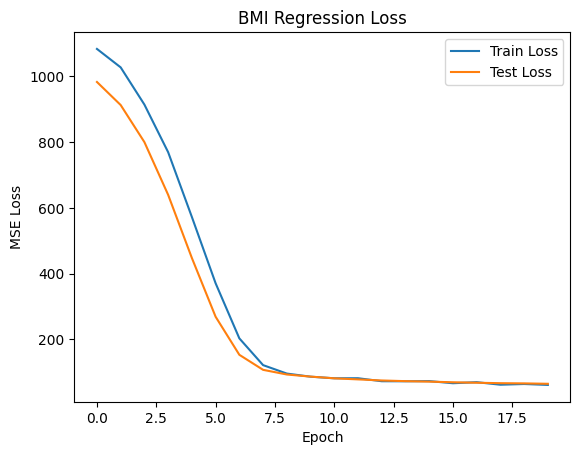

In [134]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('BMI Regression Loss')
plt.legend()
plt.show()

In [135]:
# 데이터와 타겟 분리
X = data.drop('BMI', axis=1).values
y = data['BMI'].values

In [136]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [137]:
data_array = np.hstack((X, y.reshape(-1, 1)))

In [138]:
data_array.shape

(768, 8)

In [139]:
# Split sequences function
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Apply sequence transformation
n_steps = 5
X, y = split_sequences(data_array, n_steps)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [140]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((611, 5, 7), (611,), (153, 5, 7), (153,))

In [141]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader 구성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [142]:
# CNN 회귀 모델 정의
class BMICNNRegressor(nn.Module):
    def __init__(self):
        super(BMICNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(7, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * n_steps, 64)
        self.fc2 = nn.Linear(64, 1)  # 회귀 출력 1개

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [143]:
# 모델 초기화 및 요약 출력
model = BMICNNRegressor()
summary(model, input_size=(7, n_steps))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             352
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 1]              65
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [144]:
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [145]:
train_losses = []
test_losses = []

In [146]:
# 학습 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    test_losses.append(total_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch 1, Train Loss: 1063.3006, Test Loss: 1022.2848
Epoch 2, Train Loss: 789.2438, Test Loss: 476.8963
Epoch 3, Train Loss: 208.0760, Test Loss: 108.7329
Epoch 4, Train Loss: 102.6817, Test Loss: 71.6498
Epoch 5, Train Loss: 80.8730, Test Loss: 58.6976
Epoch 6, Train Loss: 73.0287, Test Loss: 57.0144
Epoch 7, Train Loss: 70.7900, Test Loss: 54.0969
Epoch 8, Train Loss: 68.7261, Test Loss: 53.7618
Epoch 9, Train Loss: 67.9395, Test Loss: 51.7416
Epoch 10, Train Loss: 76.9634, Test Loss: 50.8488
Epoch 11, Train Loss: 63.7073, Test Loss: 48.9550
Epoch 12, Train Loss: 62.1455, Test Loss: 48.4681
Epoch 13, Train Loss: 67.6615, Test Loss: 47.7129
Epoch 14, Train Loss: 60.0490, Test Loss: 47.2054
Epoch 15, Train Loss: 58.1758, Test Loss: 46.0940
Epoch 16, Train Loss: 56.2907, Test Loss: 45.5621
Epoch 17, Train Loss: 59.3971, Test Loss: 45.9973
Epoch 18, Train Loss: 54.4952, Test Loss: 46.4412
Epoch 19, Train Loss: 55.7198, Test Loss: 44.0469
Epoch 20, Train Loss: 52.9009, Test Loss: 43.2455


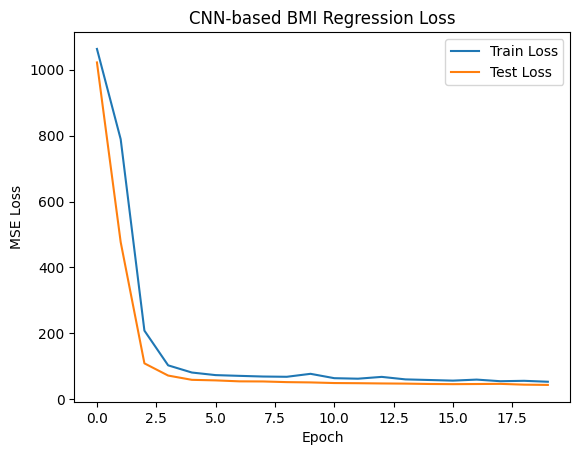

In [147]:
# 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN-based BMI Regression Loss')
plt.legend()
plt.show()

In [148]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 모델 평가 모드
model.eval()
with torch.no_grad():
    preds = model(X_test)

# 지표 계산
mae = mean_absolute_error(y_test.numpy(), preds.numpy())
rmse = np.sqrt(mean_squared_error(y_test.numpy(), preds.numpy()))
r2 = r2_score(y_test.numpy(), preds.numpy())

# 출력
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 5.3333
RMSE: 6.6593
R² Score: 0.0237
